Data is from the 2022 NBA season and it directly downloaded from the basketball-reference.com website. The data set consists of 628 rows and consists of per-game stats. 

Link: https://www.basketball-reference.com/leagues/NBA_2023_per_game.html 

The classification is based on if someone got an award based on field goal percentage and steals per game.

I will be comparing logistic regression with gradience decent and support-vector machines and comparing their accuracy of classification. 

Since the data is not linearly seperable whatsoever, I predict that these algorithms will do very poorly. 

In [ ]:

#Importing data and cleaning data
import pandas as pd

df = pd.read_csv('NBA2022.csv')

df['isAward'] = df['Awards'].notna().astype(int)

df_per_game_final = df[['FG%', 'STL', 'isAward']]

numRows = len(df_per_game_final)

df_per_game_final = df_per_game_final.dropna()

df_per_game_final = df_per_game_final.sample(frac=1)


print(df_per_game_final.head())


       FG%  STL  isAward
44   0.415  1.2        0
449  0.431  0.7        0
595  0.571  0.7        0
111  0.448  1.0        1
578  0.750  0.3        0


In [3]:
import numpy as np

class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after training.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.) # changed _ to 64 #LS
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [4]:
#Seperating between train and test and 

y = df_per_game_final.iloc[0:numRows, 2].values
X = df_per_game_final.iloc[0:numRows, [0,1]].values

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)
print('Training target shape:', y_train.shape)
print('Testing target shape:', y_test.shape)

Training data shape: (439, 2)
Testing data shape: (189, 2)
Training target shape: (439,)
Testing target shape: (189,)


In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt



def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    #edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set') 

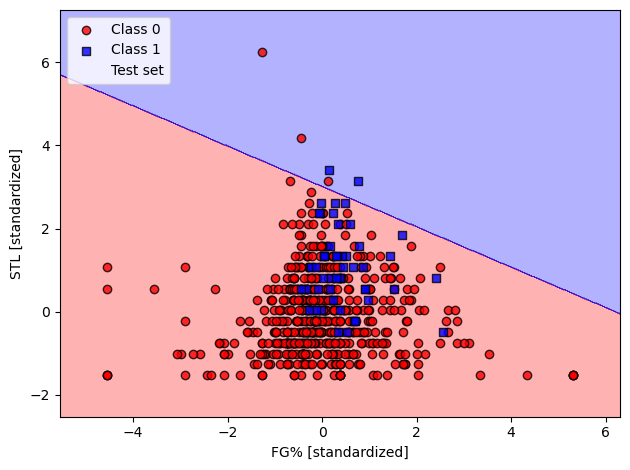

In [6]:
#Logisitic Regression

lrgd = LogisticRegressionGD(eta=.5, n_iter=1000, random_state=1)
lrgd.fit(X_train_std, y_train)

plot_decision_regions(X=X_combined_std, 
                      y=y_combined,
                      classifier=lrgd,
                      test_idx=range(439, 628))

plt.xlabel('FG% [standardized]')
plt.ylabel('STL [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_05.png', dpi=300)
plt.show()

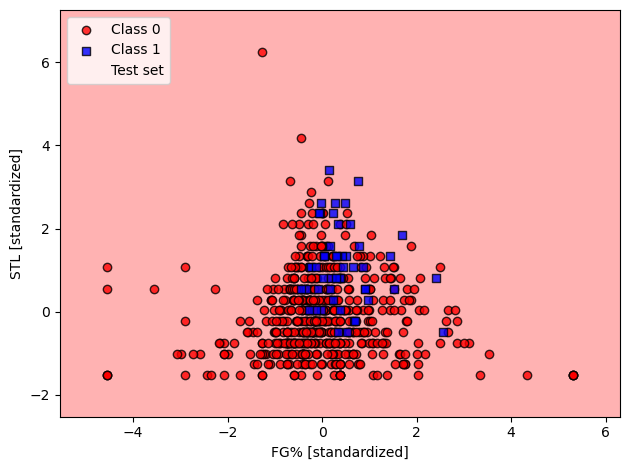

In [7]:
#SVM, tried rbf and it's even worse. 

from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(439, 628))
plt.xlabel('FG% [standardized]')
plt.ylabel('STL [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_11.png', dpi=300)
plt.show()



In [8]:
#Actually comparing accuracy of the testing data between the two models

y_pred = lrgd.predict(X_test)
lrgd_accuracy = np.mean(y_pred == y_test)
print("Logistic Regression with Gradient Descent Accuracy:", lrgd_accuracy )


svm_accuracy = svm.score(X_test, y_test)
print("SVM Accuracy:", svm_accuracy)

Logistic Regression with Gradient Descent Accuracy: 0.9153439153439153
SVM Accuracy: 0.9206349206349206


It seems that the model actually does a pretty good job of predicting whether or not a player will get an end-of-season award based on their field goal percentage and steals per game. 

However, the model is actually just blindly predicting that practically nobody will get an award as you can see for both models, so if the testing sample had a high concentration of players with awards, then the models would not be great in terms of accuracy.

In logisitic regression, it would only predict 5 players would get an end of season award, even though 3 of them actually did not get it. Also, the SVM predicts that everyone will not get an award, which is not true at all. 

Therefore, this is not generalizable and should be taken with a heavy grain of salt. Basically, the models just got lucky that the testing data had a lot of people who did not get awards.  